In [11]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

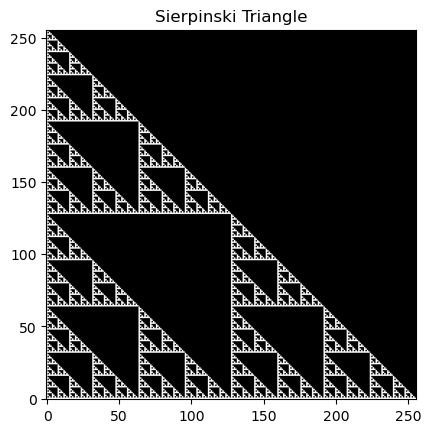

Fractal Dimension (Perimeter-Area Relation): 2.001
Fractal Dimension (Box-Counting Method): 1.579
Theoretical Fractal Dimension: 1.585


In [12]:
from skimage.measure import perimeter

def sierpinski_triangle(n):
    """Generate a Sierpinski Triangle of order n in a 2D binary array."""
    size = 2 ** n
    triangle = np.zeros((size, size), dtype=int)

    # Function to fill in the Sierpinski Triangle pattern
    def fill_triangle(x, y, size):
        if size == 1:
            triangle[x, y] = 1
        else:
            new_size = size // 2
            fill_triangle(x, y, new_size)
            fill_triangle(x + new_size, y, new_size)
            fill_triangle(x, y + new_size, new_size)

    fill_triangle(0, 0, size)
    return triangle

def fractal_dimension_perimeter_area(mask):
    """Calculate the fractal dimension using the perimeter-area relation."""
    area = np.sum(mask)
    perim = perimeter(mask)
    fractal_dimension = 2 * np.log(perim) / np.log(area)
    return fractal_dimension

def box_counting_fractal_dimension(mask):
    """Estimate the fractal dimension of a binary mask using the box-counting method."""
    binary_image = mask.astype(int)
    
    # Define a range of box sizes (logarithmically spaced)
    min_box_size = 2  # Minimum box size (should be >= 2)
    max_box_size = min(mask.shape) // 2  # Maximum box size
    box_sizes = np.logspace(np.log2(min_box_size), np.log2(max_box_size), num=10, base=2, dtype=int)

    counts = []
    for size in box_sizes:
        count = 0
        for x in range(0, mask.shape[0], size):
            for y in range(0, mask.shape[1], size):
                if np.any(binary_image[x:x+size, y:y+size]):
                    count += 1
        counts.append(count)

    # Perform a linear fit on the log-log plot
    log_box_sizes = np.log(np.array(box_sizes))
    log_counts = np.log(counts)
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    fractal_dimension = -coeffs[0]

    return fractal_dimension

# Generate a Sierpinski Triangle of order 6
sierpinski = sierpinski_triangle(8)
plt.imshow(sierpinski, cmap='gray', origin='lower')
plt.title("Sierpinski Triangle")
plt.show()

# Calculate the fractal dimension using the perimeter-area relation
fractal_dim = fractal_dimension_perimeter_area(sierpinski)
print(f"Fractal Dimension (Perimeter-Area Relation): {fractal_dim:.3f}")

# Calculate the fractal dimension using the box-counting method
fractal_dim_box_counting = box_counting_fractal_dimension(sierpinski)
print(f"Fractal Dimension (Box-Counting Method): {fractal_dim_box_counting:.3f}")

true_value = np.log10(3)/np.log10(2)
print(f"Theoretical Fractal Dimension: {true_value:.3f}")

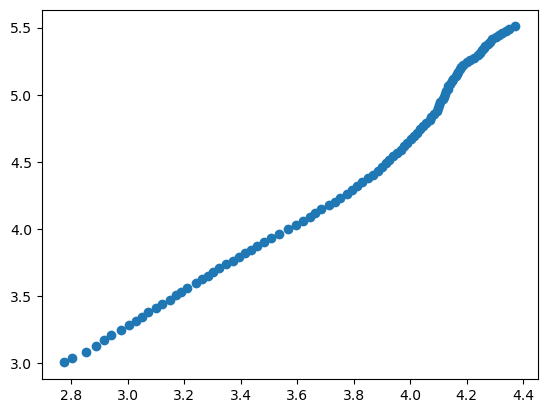

Overall Fractal Dimension: 1.2493988401572256
Instantaneous Fractal Dimensions: [2.596700799069918, 1.6503053856418646, 1.4460395766719918, 1.323279468878482, 1.2575135874970285, 1.7965974601173589, 1.072040030195037, 1.062490533330675, 1.208326381050922, 0.28850081822535606, 0.7679230482385722, 0.7659727423789094, 0.8719389130435449, 1.456479572451119, 1.6529746317762573, 1.2876577121895214, 1.628531576073967, 1.0508849853435775, 0.1955828798108526, 0.6786298030434345, 0.4963687605537594, 0.3197526785247754, 1.1363846911670357, 0.6147128287953659, 0.5890511013836073, 0.7818271066322476, 0.1560783991684997, 0.7512455195403461, 0.49531582915612865, 0.3476319044087751, 0.2615677698360269, 0.8696832160358976, 0.4441259742530558, 0.33576503623914306, 0.45970404873028586, 0.6662163276966425, 0.8847469009930213, 0.5322283633364284, 1.17448867266039, 0.9070517401414687, 0.7551298197733063, 0.8907779321795664, 0.845522953850645, 0.9366561714410335, 1.119702525616323, 0.9251178298552712, 0.6667

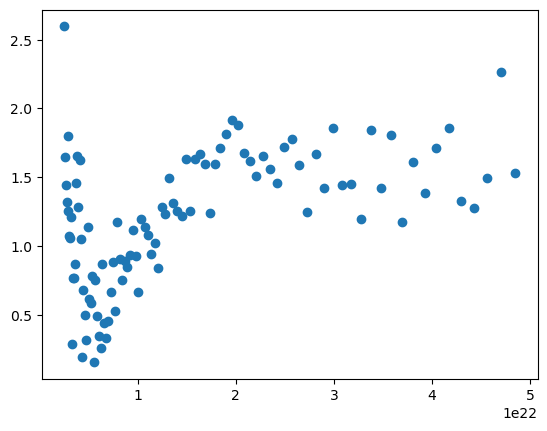

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import perimeter
from scipy.optimize import curve_fit

# Function to calculate fractal dimension
def calculate_fractal_dimension(column_density_map, thresholds):
    """
    Calculate the fractal dimension of a column density map.

    Parameters:
        column_density_map (2D numpy array): The column density map.
        thresholds (list or numpy array): Array of threshold values to segment the map.

    Returns:
        overall_fractal_dimension (float): Fractal dimension from the overall slope of the log(P)-log(A) relation.
        instantaneous_dimensions (list): List of instantaneous fractal dimensions between data points.
    """
    # Storage for areas and perimeters
    areas = []
    perimeters = []

    # Loop through thresholds
    for threshold in thresholds:
        # Binarize the map at the threshold
        binary_map = column_density_map >= threshold

        # Calculate the area
        area = np.sum(binary_map)
        areas.append(area)

        perim = perimeter(binary_map)
        perimeters.append(perim)


    # Convert to logarithmic scale
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    plt.scatter(log_perimeters, log_areas)
    plt.show()

    # Fit a line to the log-log data to get the overall fractal dimension using polyfit
    coeffs = np.polyfit(log_perimeters, log_areas, 1)
    overall_fractal_dimension = 2/coeffs[0]  # Slope of the line

    # Calculate instantaneous fractal dimensions
    instantaneous_dimensions = []
    for i in range(1, len(log_areas)):
        slope = 2/((log_areas[i] - log_areas[i-1]) / (log_perimeters[i] - log_perimeters[i-1])) 
        instantaneous_dimensions.append(slope)

    return overall_fractal_dimension, instantaneous_dimensions

# Example usage
if __name__ == "__main__":
    # Create a synthetic column density map
    threshold_min = 2.5e21
    threshold_max=5e22
    
    column_density_map = N_H2_OA

    # Define thresholds
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Calculate fractal dimensions
    overall_fd, instantaneous_fds = calculate_fractal_dimension(column_density_map, thresholds)

    # Print results
    print("Overall Fractal Dimension:", overall_fd)
    print("Instantaneous Fractal Dimensions:", instantaneous_fds) 

    plt.scatter(thresholds[:len(instantaneous_fds)], instantaneous_fds)
    plt.show()

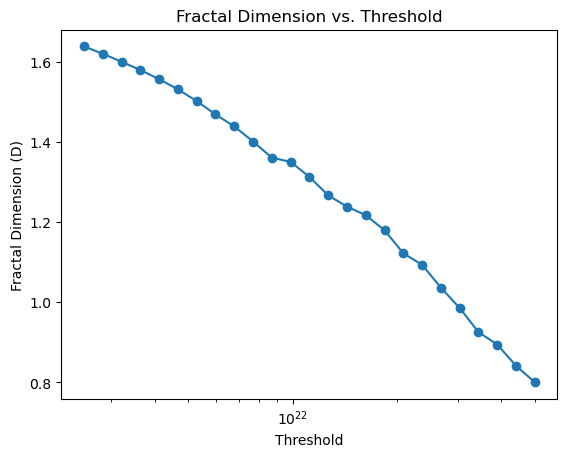

In [31]:
thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 25)

# Calculate the fractal dimension using the box-counting method for all the given thresholds
fractal_dimensions = []
for threshold in thresholds:
    binary_map = column_density_map >= threshold
    fractal_dimension = box_counting_fractal_dimension(binary_map)
    fractal_dimensions.append(fractal_dimension)

# Plot D against the thresholds
plt.plot(thresholds, fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension (D)')
plt.xscale('log')
plt.title('Fractal Dimension vs. Threshold')
plt.show()


In [32]:
print(np.mean(fractal_dimensions))

1.2780811019104363


[14:44:50] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=351468;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=847198;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

  0%|          | 0/10 [00:00<?, ?it/s]

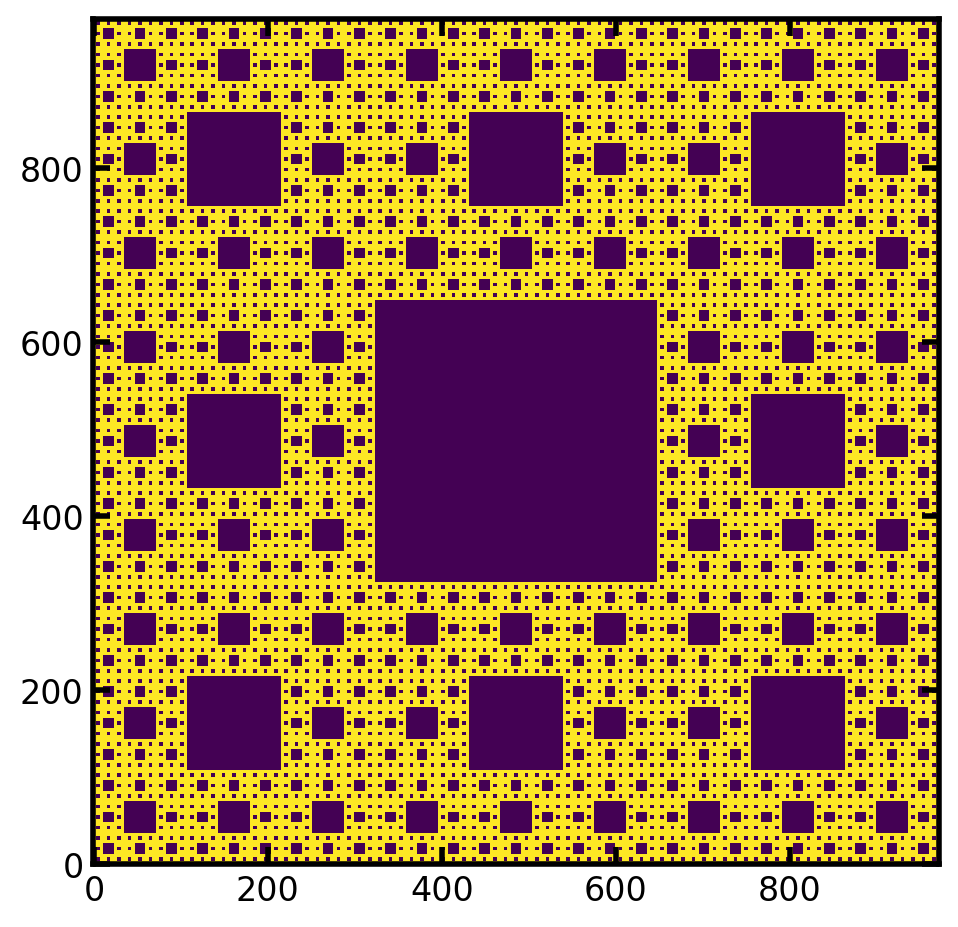

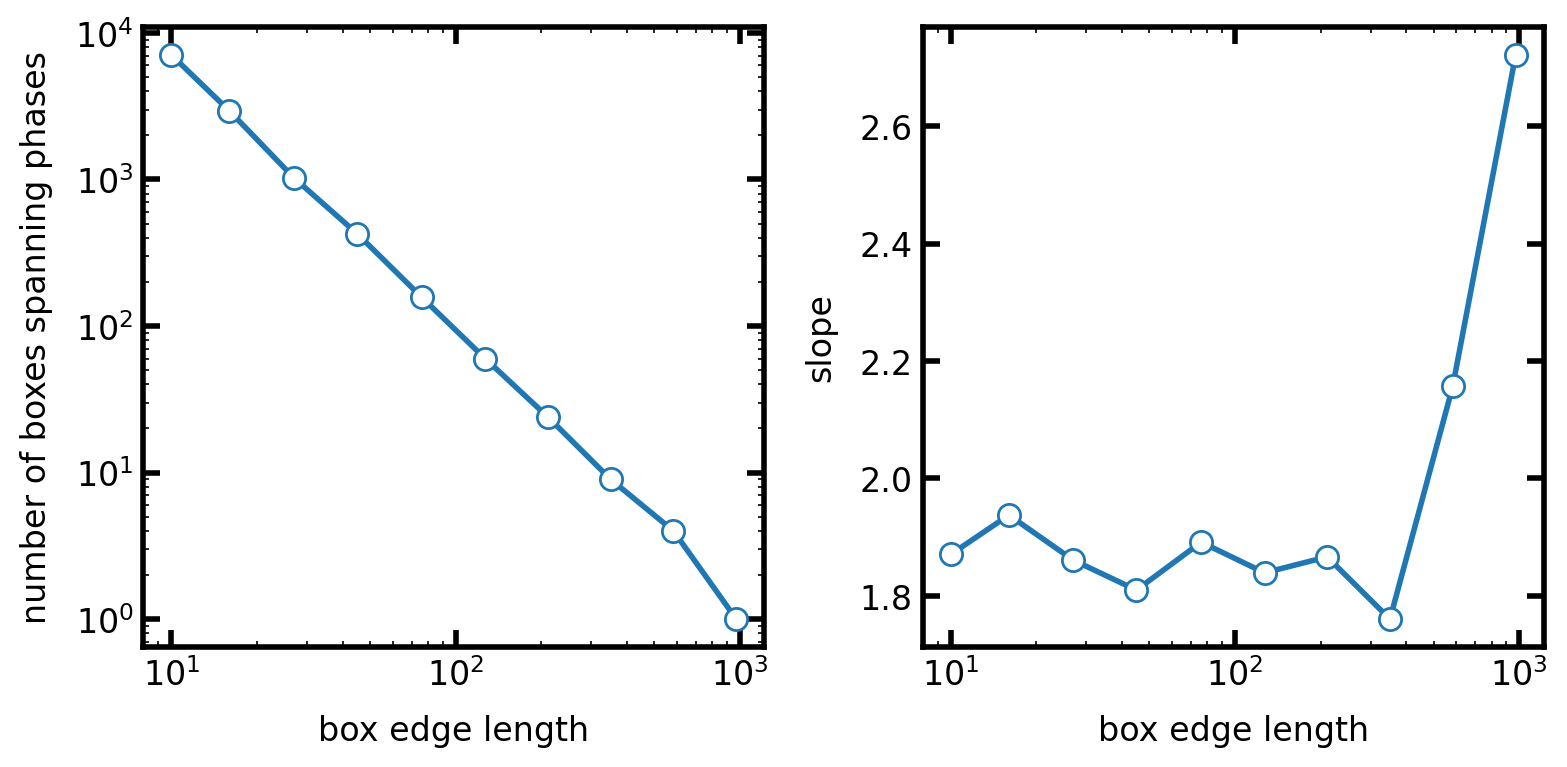

In [12]:
import matplotlib.pyplot as plt
import porespy as ps
ps.visualization.set_mpl_style()

im = ps.generators.sierpinski_foam(4, 5)
plt.imshow(im)

data = ps.metrics.boxcount(im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('box edge length')
ax1.set_ylabel('number of boxes spanning phases')
ax2.set_xlabel('box edge length')
ax2.set_ylabel('slope')
ax2.set_xscale('log')
ax1.plot(data.size, data.count,'-o')
ax2.plot(data.size, data.slope,'-o')

coeffs = np.polyfit(data.size, data.count, 1)
fractal_dimension = -coeffs[0]